# CS 328 Final Project
by: Eva Choudhury, Addie Padhi, Alisha Patil

## Imports Section

In [126]:
import os
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import glob


## Preprocessing Data and Filtering 

In [127]:
WINDOW_SIZE = 5  # in seconds
SAMPLE_RATE = 100  # Hz 
SAMPLES_PER_WINDOW = 200

def calc_magnitude(df):
    df['accel_mag'] = np.sqrt(df['x']**2 + df['y']**2 + df['z']**2)
    df['accel_mag'] -= df['accel_mag'].mean()
    return df

def remove_noise(df, sample_rate=SAMPLE_RATE):
    b, a = butter(N=2, Wn=5/(sample_rate/2), btype='low')
    df['filtered_mag'] = filtfilt(b, a, df['accel_mag'])
    return df

In [128]:
def preprocess_all_files():
    all_windows = []  

    for root, _, files in os.walk("data"):
        for fname in files:
            if not fname.endswith(".csv"):
                continue

            path = os.path.join(root, fname)
            df = pd.read_csv(path)

            df = calc_magnitude(df)
            df = remove_noise(df)

            #plot
            # plt.figure(figsize=(10, 4))
            # plt.plot(df['accel_mag'], label='Raw Magnitude', alpha=0.6)
            # plt.plot(df['filtered_mag'], label='Filtered Magnitude', linewidth=2)
            # plt.title(f"Acceleration Magnitude: {fname}")
            # plt.xlabel("Sample Index")
            # plt.ylabel("Acceleration (m/s²)")
            # plt.legend()
            # plt.tight_layout()
            # plt.show()

            label = os.path.basename(root).lower()
            samples_per_window = 200 

            for start in range(0, len(df) - samples_per_window + 1, samples_per_window):
                window = df.iloc[start:start + samples_per_window].copy()
                window["window_id"] = len(all_windows)
                window["label"] = label
                window["source_file"] = fname
                all_windows.append(window)

    if not all_windows:
        raise ValueError("no data was processed into windows")

    combined_df = pd.concat(all_windows, ignore_index=True)
    return combined_df

combined_df = preprocess_all_files()

# Feature Extraction 

In [129]:
def extract_features_from_windows(df):
    grouped = df.groupby("window_id")
    features = []

    for window_id, window in grouped:
        stats = {
            'window_id': window_id,
            'mean': window['filtered_mag'].mean(),
            'std': window['filtered_mag'].std(),
            'min': window['filtered_mag'].min(),
            'max': window['filtered_mag'].max(),
            'q25': window['filtered_mag'].quantile(0.25),
            'q75': window['filtered_mag'].quantile(0.75),
            'label': window['label'].iloc[0],
            'source_file': window['source_file'].iloc[0]
        }
        features.append(stats)
    
    features_df = pd.DataFrame(features)
    features_df.to_csv("features_for_model.csv", index=False)
    return features_df

# extract features
features_df = extract_features_from_windows(combined_df)
print(features_df)


     window_id      mean       std       min       max       q25       q75  \
0            0 -0.234512  1.165589 -1.948184  2.842849 -1.242521  0.676883   
1            1  0.334043  2.075350 -2.052507  8.462702 -1.209414  1.202556   
2            2 -0.564617  1.061081 -2.120607  2.116998 -1.420965  0.199372   
3            3  0.271722  1.027496 -1.672942  3.859845 -0.412537  0.739323   
4            4  0.650907  1.157403 -1.070952  3.577605 -0.409943  1.525664   
..         ...       ...       ...       ...       ...       ...       ...   
919        919 -0.136856  2.068618 -2.804055  3.790189 -1.796972  1.766148   
920        920 -0.081981  2.335238 -3.280305  6.101502 -2.110845  1.580252   
921        921 -0.223807  1.812223 -2.879773  3.332827 -1.818358  1.485937   
922        922  0.153934  2.440224 -3.173545  4.360758 -2.138896  2.502296   
923        923 -0.295548  2.342442 -3.457322  4.706578 -2.194617  1.462221   

          label          source_file  
0    downstairs  eva-dow

# Modeling and Evaluation

Label counts:
 label
falls         99
standing      96
walk-fast     96
downstairs    95
upstairs      94
walk-slow     94
lying         93
sitting       90
walk-mod      89
jogging       78
Name: count, dtype: int64
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.97       165
           1       0.74      0.70      0.72        20

    accuracy                           0.94       185
   macro avg       0.85      0.83      0.84       185
weighted avg       0.94      0.94      0.94       185



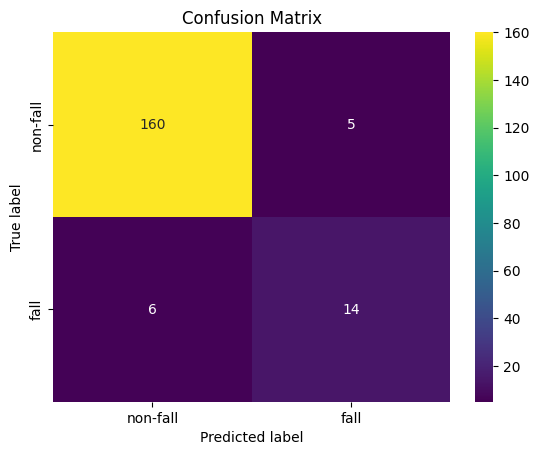

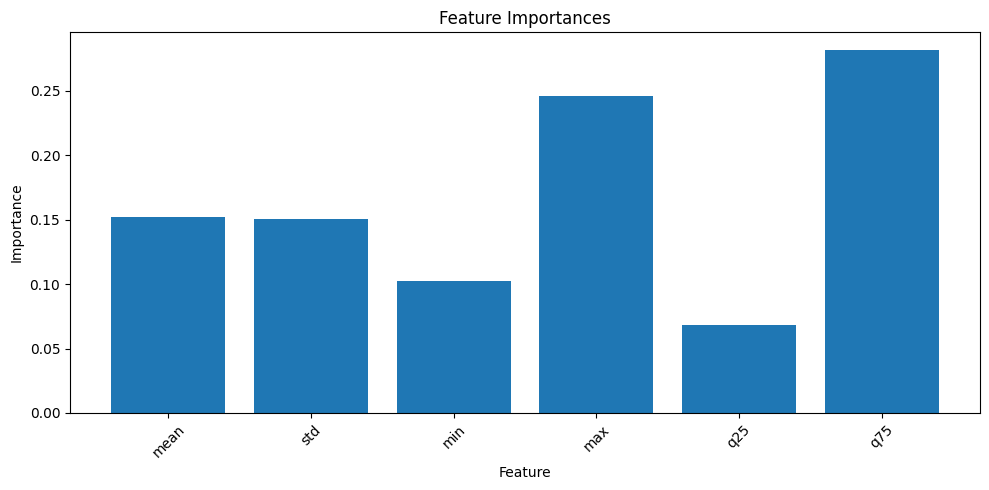

In [130]:
features_df = pd.read_csv("features_for_model.csv")
print("Label counts:\n", features_df["label"].value_counts())

features_df["label"] = features_df["label"].map(lambda x: "fall" if x == "falls" else "non-fall")


features_df = features_df.dropna()

X = features_df.drop(columns=["label", "window_id", "source_file"])
y = features_df["label"].map({'fall': 1, 'non-fall': 0})


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis',
            xticklabels=["non-fall", "fall"],
            yticklabels=["non-fall", "fall"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()


importances = model.feature_importances_
feature_names = X_train.columns

plt.figure(figsize=(10, 5))
plt.bar(feature_names, importances)
plt.title("Feature Importances")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
